In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings("ignore")

In [2]:
def feature_selection(data, top_attribute, label):
    data = data.dropna()
    predictors = data.loc[:, data.columns != label]
    class_label = data.loc[:, data.columns == label]
    
    # apply SelectKBest class to extract top 10 best features
    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    bestfeatures = SelectKBest(score_func=f_regression, k='all')
    fit = bestfeatures.fit(predictors, class_label)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(predictors.columns)
    
    # concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    
    # naming the dataframe columns
    featureScores.columns = ['Predictors','Score']  
    
    # print 10 best features
    ranked_features = featureScores.sort_values(by='Score',ascending=False)
    ranked_features = ranked_features.reset_index()
    ranked_features = ranked_features.drop(['index'], axis = 1)
    
    # creating columns names for the selected features
    data = data.reset_index()
    top_attributes_list = ['Date']
    top_attributes_list.extend(ranked_features['Predictors'].tolist()[:top_attribute])
    top_attributes_list.extend([label])
    
    # create dataframe of the selected features
    data = data[top_attributes_list]
    data = data.set_index('Date')
    return data

In [3]:
def find_best_parameters(dataset, algorithm, top_attribute):
    data = feature_selection(dataset, top_attribute, label='PCI')
    X = data.iloc[:-1,:-1].values
    y = data.iloc[:-1,-1:].values
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,shuffle=True)
    
    if algorithm == 'AdaBoost':
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.ensemble import AdaBoostRegressor
        model = AdaBoostRegressor()
        param_search = {'n_estimators' : [10,50,100],
                        'learning_rate': [i for i in np.arange(0.1,1.0,0.1)],
                        'loss'         : ['linear', 'square', 'exponential'],
                        'random_state' : [0, 21, 42]}
            
    elif algorithm == 'Random Forest':
        from sklearn.ensemble import RandomForestRegressor
        model = RandomForestRegressor()
        param_search = {'n_estimators': [10,50,100],
                        'max_features': ['auto', 'sqrt', 'log2'],
                        'max_depth'   : [i for i in range(5,15)]}
        
    elif algorithm == 'XGBoost':
        from xgboost import XGBRegressor
        model = XGBRegressor()
        param_search = {'n_estimators' : [10,50,100],
                        'learning_rate': [i for i in np.arange(0.1,1.0,0.1)],
                        'max_depth'    : [i for i in range(5,15)],
                        'random_state' : [0, 21, 42]}
        
    elif algorithm == 'Bagging':
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.ensemble import BaggingRegressor
        model = BaggingRegressor(base_estimator=DecisionTreeRegressor())
        param_search = {'n_estimators' : [10,50,100],
                        'max_samples'  : [i for i in range(1,len(data))],
                        'max_features' : [i for i in range(1,len(data.columns))],
                        'random_state' : [0, 21, 42]}
        
    tscv = TimeSeriesSplit(n_splits=len(X_train)-1)
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import mean_squared_error
    gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_root_mean_squared_error')
    gsearch.fit(X_train, y_train)
#     print('The RMSE of the best parameters for', algorithm, 'is {0:.2f}'.format(abs(gsearch.best_score_)))
    return gsearch.best_params_

In [4]:
adaboost_df      = pd.read_csv('AdaBoost Dataset.csv',parse_dates=[0])
xgboost_df       = pd.read_csv('XGBoost Dataset.csv',parse_dates=[0])
bagging_df       = pd.read_csv('Bagging Dataset.csv',parse_dates=[0])
random_forest_df = pd.read_csv('Random Forest Dataset.csv',parse_dates=[0])

adaboost_df      = adaboost_df.set_index('Date')
xgboost_df       = xgboost_df.set_index('Date')
bagging_df       = bagging_df.set_index('Date')
random_forest_df = random_forest_df.set_index('Date')

In [7]:
def generate_optimisation_heatmap(dataset, algorithm, use_gridsearch = False):
    split_rmse = []
    for i in tqdm(range(1,len(dataset.columns))):
        data = feature_selection(dataset, label='PCI', top_attribute=i)
            
        X = data.iloc[:,:-1].values
        y = data.iloc[:,-1:].values
        
        if use_gridsearch == False:
            for j in np.arange(0.1,0.4,0.05):
                from sklearn.model_selection import train_test_split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=42,shuffle=True)
                    
                if algorithm == 'AdaBoost':
                    from sklearn.tree import DecisionTreeRegressor
                    from sklearn.ensemble import AdaBoostRegressor
                    regr = AdaBoostRegressor()
                    regr.fit(X_train, y_train)
                    
                elif algorithm == 'Random Forest':
                    from sklearn.ensemble import RandomForestRegressor
                    regr = RandomForestRegressor()
                    regr.fit(X_train, y_train)
                    
                elif algorithm == 'XGBoost':
                    from xgboost import XGBRegressor
                    regr = XGBRegressor(objective='reg:squarederror')
                    regr.fit(X_train, y_train)
                    
                elif algorithm == 'Bagging':
                    from sklearn.tree import DecisionTreeRegressor
                    from sklearn.ensemble import BaggingRegressor
                    regr = BaggingRegressor(base_estimator=DecisionTreeRegressor())
                    regr.fit(X_train, y_train)
            
                from sklearn.metrics import mean_squared_error
                rmse = mean_squared_error(y_test, regr.predict(X_test), squared=False) 
                predictor = data.columns[:-1].values
                split_rmse.append([i, j, rmse])
            
            
        elif use_gridsearch == True:
            
            parameters = find_best_parameters(dataset, algorithm, top_attribute=i)
            
            for j in np.arange(0.1,0.4,0.05):
                from sklearn.model_selection import train_test_split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=j, random_state=42,shuffle=True)
                    
                if algorithm == 'AdaBoost':
                    from sklearn.tree import DecisionTreeRegressor
                    from sklearn.ensemble import AdaBoostRegressor
                    regr = AdaBoostRegressor(n_estimators    = parameters['n_estimators'],
                                             learning_rate   = parameters['learning_rate'],
                                             loss            = parameters['loss'],
                                             random_state    = parameters['random_state'])
                    regr.fit(X_train, y_train)
                    
                elif algorithm == 'Random Forest':
                    from sklearn.ensemble import RandomForestRegressor
                    regr = RandomForestRegressor(n_estimators = parameters['n_estimators'],
                                                 max_depth    = parameters['max_depth'],
                                                 max_features = parameters['max_features'])
                    regr.fit(X_train, y_train)
                    
                elif algorithm == 'XGBoost':
                    from xgboost import XGBRegressor
                    regr = XGBRegressor(objective='reg:squarederror',
                                        n_estimators    = parameters['n_estimators'],
                                        learning_rate   = parameters['learning_rate'],
                                        max_depth       = parameters['max_depth' ],
                                        random_state    = parameters['random_state'])
                    regr.fit(X_train, y_train)
                    
                elif algorithm == 'Bagging':
                    from sklearn.tree import DecisionTreeRegressor
                    from sklearn.ensemble import BaggingRegressor
                    regr = BaggingRegressor(base_estimator  = DecisionTreeRegressor(),
                                            n_estimators    = parameters['n_estimators'],
                                            max_samples     = parameters['max_samples'],
                                            max_features    = parameters['max_features'],
                                            random_state    = parameters['random_state'])                    
                    regr.fit(X_train, y_train)
                             
                from sklearn.metrics import mean_squared_error
                rmse = mean_squared_error(y_test, regr.predict(X_test), squared=False) 
                predictor = data.columns[:-1].values
                split_rmse.append([i, j, rmse])
                
    optimised_df = pd.DataFrame(split_rmse,columns = ['No Attributes', 'Test Split', 'RMSE'])
    aggregated_optimised_df = optimised_df.groupby(['No Attributes', 'Test Split']).agg({'RMSE':'mean'}).reset_index()
    
    import seaborn as sns
    reshaped_df = aggregated_optimised_df.pivot(index='No Attributes', columns='Test Split',values='RMSE')
    
    percent_test_size =[]
    for i in range(len(reshaped_df.columns)):
        percent_test_size.append('{percent:.1%}'.format(percent=reshaped_df.columns[i]))
    
    #cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
    ax = sns.heatmap(reshaped_df, annot=False,cmap="YlOrBr",cbar_kws={'label': 'RMSE'},xticklabels=percent_test_size).invert_yaxis()
    plt.title(str(algorithm)+'\nSplit Size vs Number of Attributes')
    optimised_parameters = aggregated_optimised_df[aggregated_optimised_df['RMSE'] == min(aggregated_optimised_df['RMSE'])].reset_index()
    print('The least RMSE achieved is', optimised_parameters['RMSE'][0])
    print('The recommended parameter is test size = {percent:.1%}'.format(percent=optimised_parameters['Test Split'][0]), '& No of top attributes = ',optimised_parameters['No Attributes'][0])
    return reshaped_df

100%|██████████| 16/16 [00:02<00:00,  5.76it/s]


The least RMSE achieved is 3328.5849355744713
The recommended parameter is test size = 10.0% & No of top attributes =  2


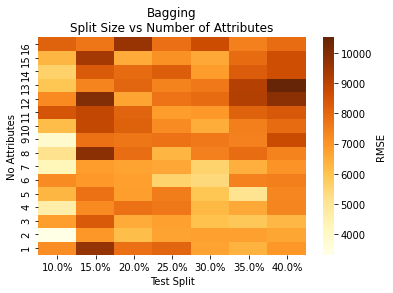

In [8]:
dataset=bagging_df
algorithm='Bagging'
bagging = generate_optimisation_heatmap(dataset, algorithm, use_gridsearch=False)

100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


The least RMSE achieved is 4368.127096647565
The recommended parameter is test size = 10.0% & No of top attributes =  9


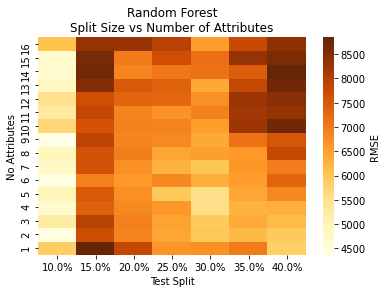

In [9]:
dataset=random_forest_df
algorithm='Random Forest'
random_forest = generate_optimisation_heatmap(dataset, algorithm, use_gridsearch=False)

100%|██████████| 16/16 [00:09<00:00,  1.65it/s]


The least RMSE achieved is 4252.460302947949
The recommended parameter is test size = 10.0% & No of top attributes =  15


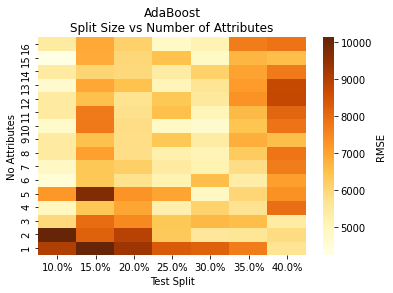

In [10]:
dataset=adaboost_df
algorithm='AdaBoost'
adaboost = generate_optimisation_heatmap(adaboost_df, algorithm, use_gridsearch=False)

100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


The least RMSE achieved is 4701.399766432069
The recommended parameter is test size = 40.0% & No of top attributes =  12


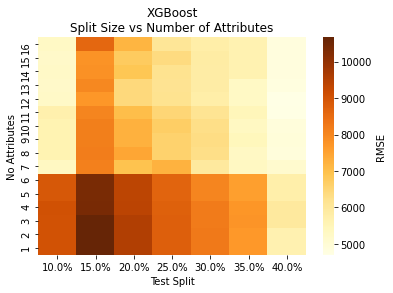

In [11]:
dataset=xgboost_df
algorithm='XGBoost'
xgboost = generate_optimisation_heatmap(xgboost_df, algorithm, use_gridsearch=False)

Text(0.5, 1.0, 'XGBoost (Random Percentage Split)')

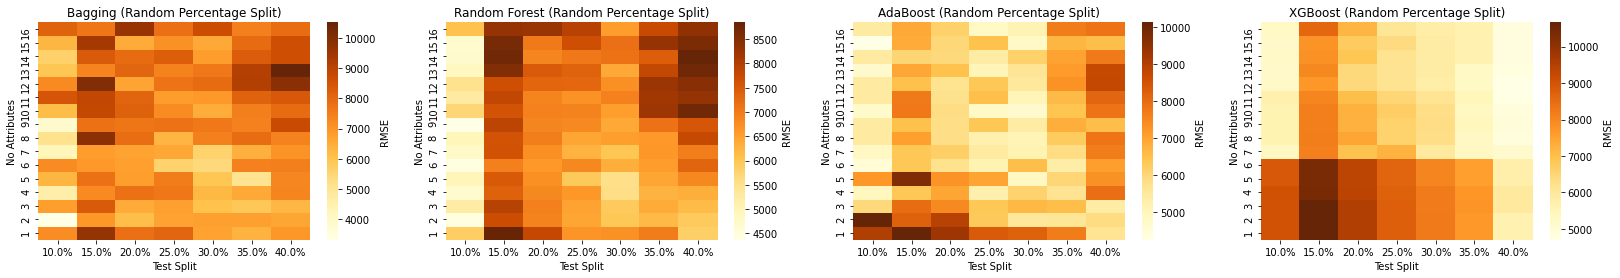

In [12]:
import seaborn as sns

percent_test_size =[]
for i in range(len(bagging.columns)):
    percent_test_size.append('{percent:.1%}'.format(percent=bagging.columns[i]))
        
f,(ax1,ax2,ax3, ax4) = plt.subplots(1, 4, sharey = False, sharex = False, figsize=(28,4))
g1 = sns.heatmap(bagging, annot=False,cmap="YlOrBr",cbar_kws={'label': 'RMSE'},xticklabels=percent_test_size, ax=ax1).invert_yaxis()
g2 = sns.heatmap(random_forest, annot=False,cmap="YlOrBr",cbar_kws={'label': 'RMSE'},xticklabels=percent_test_size, ax=ax2).invert_yaxis()
g3 = sns.heatmap(adaboost, annot=False,cmap="YlOrBr",cbar_kws={'label': 'RMSE'},xticklabels=percent_test_size, ax=ax3).invert_yaxis()
g4 = sns.heatmap(xgboost, annot=False,cmap="YlOrBr",cbar_kws={'label': 'RMSE'},xticklabels=percent_test_size, ax=ax4).invert_yaxis()

ax1.set_title('Bagging (Random Percentage Split)')
ax2.set_title('Random Forest (Random Percentage Split)')
ax3.set_title('AdaBoost (Random Percentage Split)')
ax4.set_title('XGBoost (Random Percentage Split)')

# ----------------------------------------------------------------------------------------------------------------

100%|██████████| 16/16 [5:27:53<00:00, 1229.60s/it]  


The least RMSE achieved is 19881.031955538492
The recommended parameter is test size = 30.0% & No of top attributes =  7


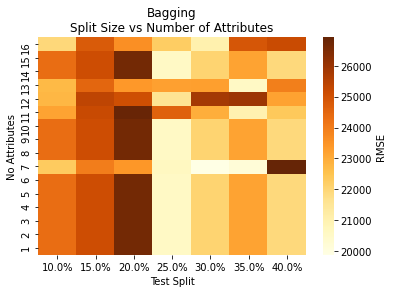

In [30]:
dataset=bagging_df
algorithm='Bagging'
generate_optimisation_heatmap(dataset, algorithm, use_gridsearch=True)

100%|██████████| 16/16 [27:43<00:00, 103.98s/it]


The least RMSE achieved is 3525.5149543482794
The recommended parameter is test size = 10.0% & No of top attributes =  13


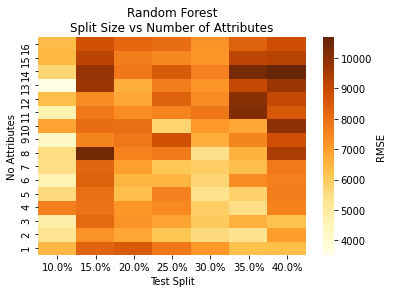

In [28]:
dataset=random_forest_df
algorithm='Random Forest'
generate_optimisation_heatmap(dataset, algorithm, use_gridsearch=True)

100%|██████████| 16/16 [1:04:18<00:00, 241.13s/it]


The least RMSE achieved is 3061.1504373356106
The recommended parameter is test size = 10.0% & No of top attributes =  7


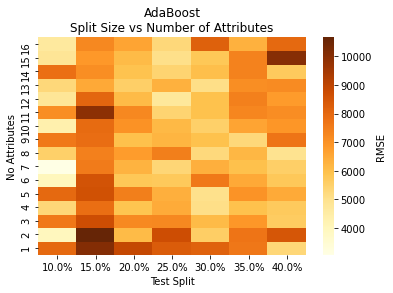

In [32]:
dataset=adaboost_df
algorithm='AdaBoost'
generate_optimisation_heatmap(adaboost_df, algorithm, use_gridsearch=True)

In [ ]:
dataset=xgboost_df
algorithm='XGBoost'
generate_optimisation_heatmap(xgboost_df, algorithm, use_gridsearch=True)

  6%|▋         | 1/16 [5:24:10<81:02:37, 19450.50s/it]